In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = torch.load('model_conv.pth', map_location=device)
model = model.eval()

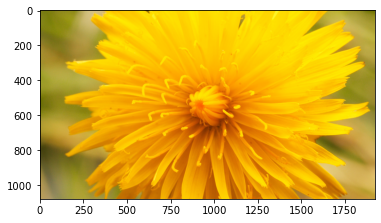

In [3]:
from PIL import Image
from torchvision import transforms
img = Image.open("flower_photos/Dandelion.jpg")

#preprocess = transforms.Compose([
#        transforms.Resize(256),
#        transforms.CenterCrop(224),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#])

#img = preprocess(im)
#img = img.unsqueeze(0)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transformed_img = transform(img)

input = transformed_img.unsqueeze(0)

imgplot = plt.imshow(img)

In [8]:
transformed_img.numpy().ndim

3

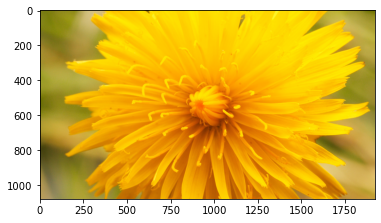

In [12]:
image = Image.fromarray(transformed_img.numpy(), "RGB")
plt.imshow(img)

In [4]:
labels = np.array(open("class.txt").read().splitlines())

In [6]:
output = model(input)
output = F.softmax(output, dim=1)

In [7]:
prediction_score, pred_label_idx = torch.topk(output, 1)

In [8]:
prediction_score

tensor([[0.9513]], grad_fn=<TopkBackward>)

In [9]:
pred_label_idx.squeeze_()

tensor(1)

In [10]:
labels = np.array(open("class.txt").read().splitlines())

In [11]:
labels[torch.argmax(output)]

'dandelion'

In [12]:
labels[pred_label_idx.squeeze_()]

'dandelion'

In [13]:
input.requires_grad = True
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = labels[pred_label_idx.squeeze_()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: dandelion ( 0.9512578248977661 )


In [14]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,target=pred_label_idx,**kwargs)
    
    return tensor_attributions
        

In [15]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=pred_label_idx)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))


In [16]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.7860], dtype=torch.float64)


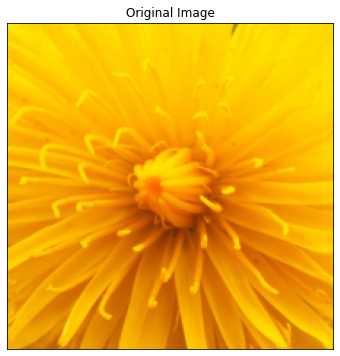

In [14]:
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

original_image = inv_normalize(input)
original_image1 = np.transpose(original_image.squeeze().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr(None, original_image1, 
                      method="original_image", title="Original Image")

In [29]:
original_image1

array([[[1.        , 0.90980387, 0.        ],
        [0.99607843, 0.9019608 , 0.        ],
        [1.        , 0.89411765, 0.        ],
        ...,
        [0.99607843, 0.88627446, 0.00392158],
        [0.99607843, 0.89411765, 0.00392158],
        [0.99607843, 0.8784314 , 0.00784313]],

       [[1.        , 0.91372544, 0.        ],
        [1.        , 0.90980387, 0.        ],
        [1.        , 0.90588236, 0.        ],
        ...,
        [0.99607843, 0.8784314 , 0.00392158],
        [0.99607843, 0.87058824, 0.00392158],
        [0.99607843, 0.8666667 , 0.00392158]],

       [[1.        , 0.90588236, 0.        ],
        [1.        , 0.90980387, 0.        ],
        [0.99607843, 0.90980387, 0.        ],
        ...,
        [1.        , 0.8509804 , 0.00392158],
        [0.99607843, 0.85882354, 0.        ],
        [1.        , 0.87058824, 0.        ]],

       ...,

       [[0.9529411 , 0.6666667 , 0.00392158],
        [0.9529411 , 0.6745098 , 0.00392158],
        [0.9529411 , 0

In [34]:

im = Image.fromarray((original_image1 * 255).astype(np.uint8))

In [31]:
import cv2
img = cv2.cvtColor(original_image1, cv2.COLOR_RGB2BGR)
_, buffer = cv2.imencode('.jpg', img)
#return base64.b64encode(buffer).decode('utf-8')

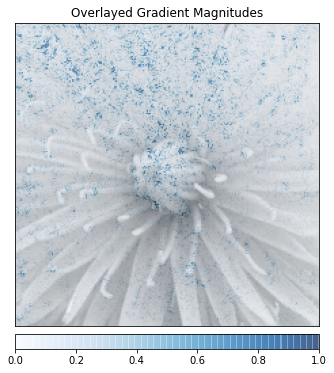

In [18]:
_ = viz.visualize_image_attr(grads, original_image1, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

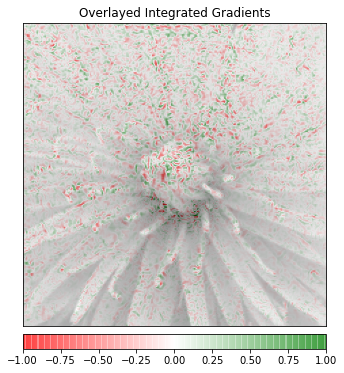

In [19]:
_ = viz.visualize_image_attr(attr_ig, original_image1, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

In [20]:
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(input, strides = (3, 8, 8), target=pred_label_idx, sliding_window_shapes=(3,15, 15), baselines=0)
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0))


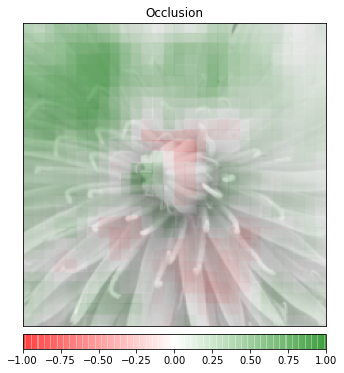

In [21]:
_ = viz.visualize_image_attr(attributions_occ, original_image1, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Occlusion")